In [1]:
import fastbook
fastbook.setup_book()

In [2]:
from fastai.vision.all import *
from fastbook import plot_function
from fastbook import search_images_bing
from fastbook import search_images_ddg
from fastbook import download_url

In [3]:
results = search_images_ddg('grizzly bear', 10)

In [4]:
results[0]

'https://wallup.net/wp-content/uploads/2017/11/22/393678-bears-sadness-Grizzly_bear-brown_bear-Grizzly_Bears.jpg'

In [5]:
dest = 'ignore/images/grizzly2.jpg'
download_url(results[0], dest)

Path('ignore/images/grizzly2.jpg')

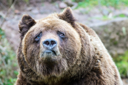

In [6]:
im = Image.open(dest)
im.to_thumb(128,128)

In [7]:
bear_types = ['grizzly', 'black', 'teddy']
# bear_types = ['teddy', 'teddy', 'teddy']

In [8]:
path = Path('ignore/bears')

In [9]:
if not path.exists():
    path.mkdir()
    
for o in bear_types:
    print(o)
    dests = (path/o)
    dests.mkdir(exist_ok=True)
    # print(f'{o} bear')
    ro = search_images_ddg(f'{o} bear', 150)
    # print(ro)
    download_images(dests, urls=ro)

grizzly
black
teddy


In [10]:
fns = get_image_files(path)
fns

(#422) [Path('ignore/bears/black/34ea4cc7-4d8a-4e43-b789-01eca3b96d89.JPG'),Path('ignore/bears/black/dec7761c-8015-4262-8e32-d3f17b29110f.jpg'),Path('ignore/bears/black/540947a5-4533-494d-8de3-7b4eb41a5cbb.jpg'),Path('ignore/bears/black/fe256451-328a-4077-8ca3-b5bf39c40c22.jpg'),Path('ignore/bears/black/c992300c-ddc9-4fe9-9107-2ac204713eb4.jpg'),Path('ignore/bears/black/e29d07ca-45d0-4b48-b5df-e6a210ebd921.jpg'),Path('ignore/bears/black/2e91aa4a-63e9-4d79-b4e1-1f22a96bbbbf.jpg'),Path('ignore/bears/black/50d33344-2c5a-4018-8ecc-d3b462bdd47c.jpg'),Path('ignore/bears/black/d054e72b-66a0-41a6-8737-2af6cb94181b.jpg'),Path('ignore/bears/black/e6fb9903-765f-42c2-a148-c7243963dcac.jpg')...]

In [11]:
failed = verify_images(fns)
failed

(#23) [Path('ignore/bears/black/0bde7c7d-356a-4ba6-8df6-ab58fae402d0.jpg'),Path('ignore/bears/black/d2b7298e-b227-4109-b40b-29421110dd31.JPG'),Path('ignore/bears/black/0f2c4f1b-d971-41b7-978b-c2cc4f687084.jpg'),Path('ignore/bears/black/4dd181cc-eaa2-4d7c-aa76-ec09058eecba.jpg'),Path('ignore/bears/black/4b1018ce-8fe5-46eb-b3bf-4d6f33dd84b7.jpg'),Path('ignore/bears/black/f1639c96-a8df-4f02-b428-a1fe36cef4a9.jpg'),Path('ignore/bears/black/5255b2d5-faeb-413d-867b-e394575ee493.jpg'),Path('ignore/bears/black/27fbd1db-48f5-4050-944a-8bcaa3e748a8.jpg'),Path('ignore/bears/grizzly/24f24cf7-d6da-44e7-9d7b-9b5545cdc403.jpg'),Path('ignore/bears/grizzly/1a2686d0-0aec-409a-aa5d-9d57d6227c25.jpg')...]

In [12]:
len(failed)

23

In [13]:
failed.map(Path.unlink);

In [14]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.5), 
    batch_tfms=aug_transforms()
)

In [15]:
path

Path('ignore/bears')

In [16]:
dls = bears.dataloaders(path)

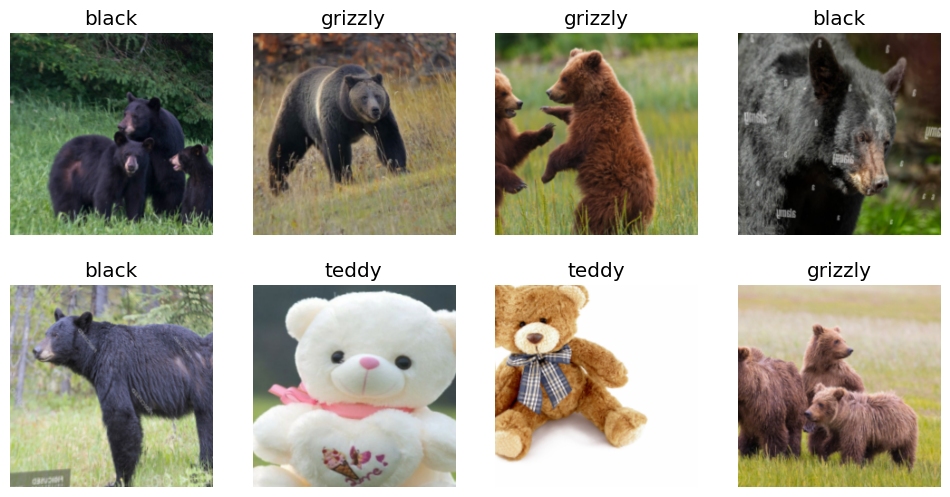

In [17]:
dls.train.show_batch(max_n=8)

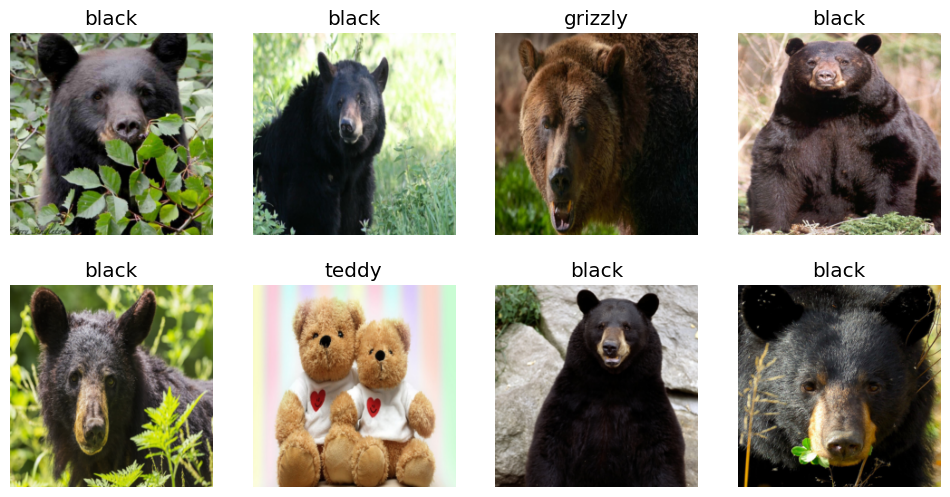

In [18]:
dls.valid.show_batch(max_n=8)

In [19]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/ubuntu/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:00<00:00, 209MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,2.440706,3.781739,0.692308,00:04


epoch,train_loss,valid_loss,error_rate,time
0,1.817898,2.690955,0.653846,00:04
1,1.882595,0.749810,0.269231,00:04
2,1.400055,0.130233,0.038462,00:04
3,1.132557,0.059452,0.000000,00:04


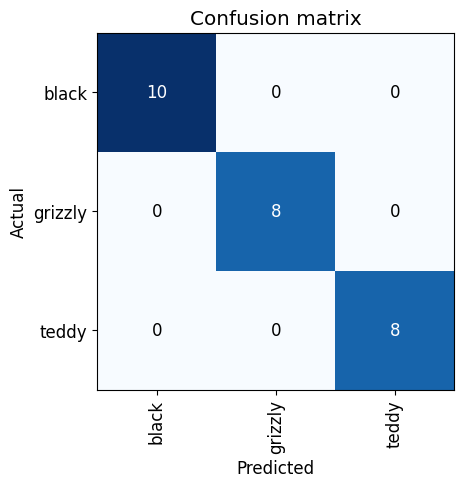

In [20]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

## Multilable

In [19]:
def get_y(r): 
    # print(type(r))
    # print((r.parent.name))
    return [r.parent.name]

dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=get_y,
    item_tfms=RandomResizedCrop(224, min_scale=0.5), 
    batch_tfms=aug_transforms()
)
# dsets = dblock.datasets(path)
dls = dblock.dataloaders(path)

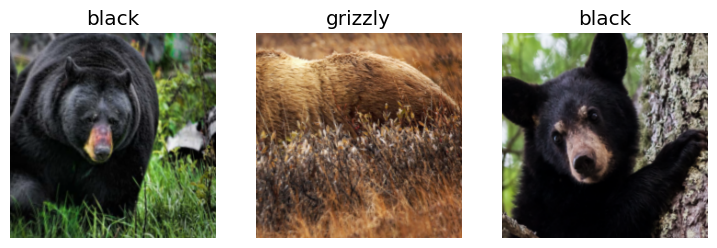

In [20]:
dls.show_batch(nrows=1, ncols=3)

In [21]:
learn = vision_learner(dls, resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/ubuntu/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:00<00:00, 96.2MB/s]


In [22]:
x, y = to_cpu(dls.train.one_batch())
activs = learn.model(x)
activs.shape, x.shape, y.shape

(torch.Size([64, 3]), torch.Size([64, 3, 224, 224]), torch.Size([64, 3]))

In [23]:
learn = vision_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.3))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /home/ubuntu/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:01<00:00, 84.2MB/s]


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.800475,0.360645,0.721519,00:06
1,0.543081,0.144544,0.898734,00:06
2,0.398591,0.099745,0.949367,00:06
3,0.317328,0.078062,0.962025,00:06


/home/ubuntu/miniconda3/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/ubuntu/miniconda3/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/ubuntu/miniconda3/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/ubuntu/miniconda3/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/ubuntu/miniconda3/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/ubuntu/miniconda3/lib/python3.12/site-packages/PI

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.088726,0.087112,0.974684,00:06
1,0.076815,0.100679,0.970464,00:06
2,0.061032,0.092182,0.970464,00:06


/home/ubuntu/miniconda3/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/ubuntu/miniconda3/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/ubuntu/miniconda3/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/ubuntu/miniconda3/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/ubuntu/miniconda3/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [24]:
learn.export()

In [25]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [26]:
learn_inf = load_learner(path/'export.pkl')

In [27]:
learn_inf.predict('ignore/images/grizzly2.jpg')

((#1) ['grizzly'],
 tensor([False,  True, False]),
 tensor([4.4486e-03, 9.9999e-01, 2.4808e-04]))

In [28]:
dogs = search_images_ddg('dog', 10)

In [29]:
dogdests = (path/'ignore'/'dogs')
dogdests.mkdir(exist_ok=True)

# print(ro)
download_images(dogdests, urls=dogs)

In [35]:
learn_inf.predict('ignore/dogs/eeed7496-b91a-4b5b-95f1-3376254923ca.jpg')

UnidentifiedImageError: cannot identify image file '/home/ubuntu/ai/ignore/dogs/eeed7496-b91a-4b5b-95f1-3376254923ca.jpg'